In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing necessary Libraries

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


#Functions for Loading Data

In [4]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[200:246,90:230,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [6]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('drive','MyDrive','unzipped','s2',f'{file_name}.mpg')
    alignment_path = os.path.join('drive','MyDrive','unzipped','s2',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [7]:
test_path ='/content/drive/MyDrive/unzipped/s2/bbaf1n.mpg'

In [8]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

In [9]:
print(len(frames),len(alignments))

75 21


In [ ]:
frames

In [11]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 15, 14,  5,
       39, 14, 15, 23])>

In [12]:
frames.shape

TensorShape([75, 46, 140, 1])

In [13]:
alignments.shape

TensorShape([21])

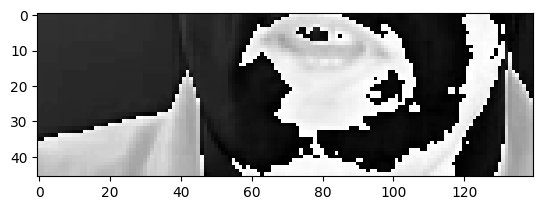

In [14]:
plt.imshow(frames[40],cmap='gray')

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f one now'>

In [16]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

#Creating the Data Pipeline

In [17]:
# data is taken from  https://spandh.dcs.shef.ac.uk//gridcorpus/
data = tf.data.Dataset.list_files('/content/drive/MyDrive/unzipped/s2/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [18]:
print(len(test),len(train))

50 450


In [19]:
frames,alignments = data.as_numpy_iterator().next()

In [ ]:
frames

In [21]:
alignments

array([[ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39,  1, 39, 15,
        14,  5, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 18,  5,  4, 39,  9, 14, 39,  9, 39, 19,
         9, 24, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [22]:
print(len(frames), len(alignments))

2 2


In [23]:
sample = data.as_numpy_iterator()

In [24]:
val = sample.next()

In [25]:
val[0][1].shape

(75, 46, 140, 1)

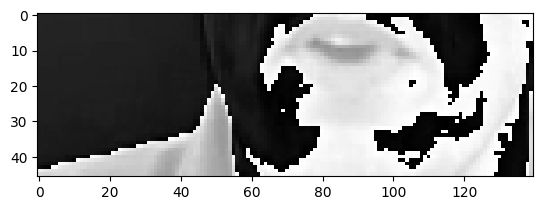

In [26]:
plt.imshow(val[0][0][30],cmap='gray')

In [27]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e zero soon'>

#Defining the model architecture


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, GRU, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [29]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(GRU(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [31]:
model.input_shape

(None, 75, 46, 140, 1)

In [32]:
model.output_shape

(None, 75, 41)

In [33]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [34]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=CTCLoss)

In [35]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [36]:
yhat[0].shape

(75, 41)

In [37]:
yhat[0]

array([[0.02629661, 0.02541274, 0.02651205, ..., 0.03317136, 0.02850657,
        0.02122677],
       [0.02308445, 0.0246847 , 0.02630053, ..., 0.03440892, 0.03152202,
        0.02332219],
       [0.02076504, 0.02273624, 0.02595497, ..., 0.03703849, 0.03404775,
        0.0251033 ],
       ...,
       [0.01953936, 0.01857015, 0.02131298, ..., 0.03748038, 0.03251223,
        0.03166057],
       [0.01986315, 0.01886691, 0.02030294, ..., 0.03422631, 0.03101444,
        0.03332011],
       [0.02103668, 0.01954498, 0.01994515, ..., 0.03027789, 0.02759016,
        0.03336871]], dtype=float32)

In [38]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeel'>

In [39]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [40]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [41]:
import os
directory = '/content/models2'
if not os.path.exists(directory):
    os.makedirs(directory)

#Training the model

In [42]:
checkpoint_callback = ModelCheckpoint(os.path.join('models2','checkpoint'), monitor='loss', save_weights_only=True)

In [43]:
schedule_callback = LearningRateScheduler(scheduler)

In [44]:
example_callback = ProduceExample(data)

# **Note: The cell's execution, specifically the one in which the model was being trained, was intentionally halted due to a KeyboardInterrupt. This interruption was made to prevent the output window from growing excessively and obstructing the visibility of the model training process.**

In [45]:
model.fit(train, validation_data = test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 0s 205ms/step
Original: set red in n four soon
Prediction: le e e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in z one please
Prediction: le e e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 707s 2s/step - loss: 80.6494 - val_loss: 73.1713 - lr: 0.0010


KeyboardInterrupt: ignored